# Section 3

Since the calculation's overhead is alot
   you can use GPU in order to  parallelize
   the calculation ...

In [1]:
# import tensorflow as tf
# from tensorflow.python.client import device_lib

# tf.test.gpu_device_name() 
# device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11261121000540878652,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3142752665
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8890173287865194506
 physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"]

## part a

In [3]:
from __future__ import absolute_import
from __future__ import print_function
import os
import itertools
import numpy as np
import scipy.io
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense, Dropout, Activation, BatchNormalization,Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, Adadelta, Adagrad ,Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# put the Train and Test mats in the Code's directory ...
Train = scipy.io.loadmat('train_32x32.mat') ## this should be replaced by a stored datapath on a GPU cluster
Test = scipy.io.loadmat('test_32x32.mat') ## this should be replaced by a stored datapath on a GPU cluster

# Supervised Learning -> Data,Label
# Train Data
X_train = Train['X']
y_train = Train['y']
# Test Data
X_test = Test['X']
y_test = Test['y']

# retyping in order to do calculation
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalizing pixels
X_train /= 255
X_test /= 255

# making the DataSets ready to use.
X_train = X_train[np.newaxis,...]
X_train = np.swapaxes(X_train,0,4).squeeze()

X_test = X_test[np.newaxis,...]
X_test = np.swapaxes(X_test,0,4).squeeze()

# Enhancing labels inOrder to use in training
# Labels should have 10 classes.
np.place(y_train,y_train == 10,0)
np.place(y_test,y_test == 10,0)

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

# now both Datasets and Labels are ready and reshaped to
# be used in CNN.

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    data_format='channels_first')


# training ...
datagen.fit(X_train)
print(X_train.shape)
datagen.flow(X_train, y_train, batch_size=128)
print(y_train.shape)

C:\Users\AmirHossein\.conda\envs\tf-gpu\lib\site-packages\keras_preprocessing\image\image_data_generator.py:940: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_first" (channels on axis 1), i.e. expected either 1, 3 or 4 channels on axis 1. However, it was passed an array with shape (73257, 32, 32, 3) (32 channels).
  ' channels).')


(73257, 32, 32, 3)
(73257, 10)


C:\Users\AmirHossein\.conda\envs\tf-gpu\lib\site-packages\keras_preprocessing\image\numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_first" (channels on axis 1), i.e. expected either 1, 3, or 4 channels on axis 1. However, it was passed an array with shape (73257, 32, 32, 3) (32 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


## part b 

model 1 
No. of conv Layers : 2 conv layers

conv Layer
conv Layer
MaxPooling
Flattening -> Since it is a one dimensional Vector.
using DropOut inOrder to prevent Module from Overfitting ...


In [12]:
from __future__ import absolute_import
from __future__ import print_function
import os
import itertools
import numpy as np
import scipy.io
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense, Dropout, Activation, BatchNormalization,Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, Adadelta, Adagrad ,Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from keras.layers import Input
# setting up batchSize and epoches ...
batch_size = 128
nb_classes = 10
nb_epoch = 20

model = Sequential()

# first Convoloution Layer
model.add(Convolution2D(128, 3, 3, border_mode='same',input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())

# second Convoloution Layer
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(BatchNormalization())

# maxPooling
# Note: You can also use MaxPooling among convoloutional Layers ...
# but Since using this sometimes decreases the amount of useful data which 
# is given to the next Layer,I prefered to use it after These two Con Layers.

model.add(MaxPooling2D(pool_size=(2, 2)))

# Using DropOut with arbitrary percent
# in Order to prevent Overfitting Ocurance.
model.add(Dropout(0.25))

# Flattening -> Since it is a one dimensional Vector.
model.add(Flatten())

# normalizing -> according to various docs using 
# batch normalization Enhances perfomance.
model.add(BatchNormalization())

# final fully connected layers

model.add(Dense(512))
model.add(Activation('relu'))
model.add(BatchNormalization())
# Using DropOut with arbitrary percent
# in Order to prevent Overfitting Ocurance.
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

# this part of Code is extracted from Github.
# Setting up AdamOptimizer(well known optimizer) -> increasing perfomance
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
adammax = keras.optimizers.Adamax(learning_rate=0.002, beta_1=0.9, beta_2=0.999)
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))

history = AccuracyHistory()

model.compile(loss='categorical_crossentropy', optimizer=adam,metrics=['accuracy'])

# training and validation ...
model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=20, verbose=1, validation_data=(X_test, y_test))

# Evaluate Accurancy ...
score = model.evaluate(X_test, y_test, verbose=0)
print('loss:', score[0])
print('accuracy:', score[1])

model.summary()

model1 = model

C:\Users\AmirHossein\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), input_shape=(32, 32, 3..., padding="same")`
C:\Users\AmirHossein\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:32: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
C:\Users\AmirHossein\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:82: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 73257 samples, validate on 26032 samples
Epoch 1/20
73257/73257 [==============================] - 83s 1ms/step - loss: 0.9158 - accuracy: 0.7282 - val_loss: 1.5838 - val_accuracy: 0.5148
Epoch 2/20
73257/73257 [==============================] - 86s 1ms/step - loss: 0.4448 - accuracy: 0.8647 - val_loss: 0.5130 - val_accuracy: 0.8422
Epoch 3/20
73257/73257 [==============================] - 87s 1ms/step - loss: 0.3587 - accuracy: 0.8898 - val_loss: 0.4114 - val_accuracy: 0.8778
Epoch 4/20
73257/73257 [==============================] - 88s 1ms/step - loss: 0.3042 - accuracy: 0.9062 - val_loss: 0.4110 - val_accuracy: 0.8808
Epoch 5/20
73257/73257 [==============================] - 88s 1ms/step - loss: 0.2705 - accuracy: 0.9163 - val_loss: 0.4044 - val_accuracy: 0.8846
Epoch 6/20
73257/73257 [==============================] - 87s 1ms/step - loss: 0.2373 - accuracy: 0.9256 - val_loss: 0.3861 - val_accuracy: 0.8916
Epoch 7/20
73257/73257 [==============================] - 86s 1ms/st

model 2 
No. of conv Layers : 3 conv layers

conv Layer
conv Layer
MaxPooling
conv Layer
MaxPooling
Flattening -> Since it is a one dimensional Vector.
using DropOut inOrder to prevent Module from Overfitting ...


In [4]:
from __future__ import absolute_import
from __future__ import print_function
import os
import itertools
import numpy as np
import scipy.io
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense, Dropout, Activation, BatchNormalization,Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, Adadelta, Adagrad ,Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from keras.layers import Input
batch_size = 128
nb_classes = 10
nb_epoch = 20

model = Sequential()

# first Convoloution Layer
model.add(Convolution2D(128, 3, 3, border_mode='same',input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())

# second Convoloution Layer
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(BatchNormalization())

# maxPooling
# Note: You can also use MaxPooling among convoloutional Layers ...
# but Since using this sometimes decreases the amount of useful data which 
# is given to the next Layer,I prefered to use it after These two Con Layers.
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# third  Convoloution Layer
model.add(Convolution2D(64, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

# Another maxPooling
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening -> Since it is a one dimensional Vector.
model.add(Flatten())
model.add(BatchNormalization())

# final fully connected layers
model.add(Dense(512))
model.add(Activation('relu'))
model.add(BatchNormalization())
# Using DropOut with arbitrary percent
# in Order to prevent Overfitting Ocurance.
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

# this part of Code is extracted from Github.
# Setting up AdamOptimizer(well known optimizer) -> increasing perfomance
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
adammax = keras.optimizers.Adamax(learning_rate=0.002, beta_1=0.9, beta_2=0.999)
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))

history = AccuracyHistory()

# training and validation ...
model.compile(loss='categorical_crossentropy', optimizer=adam,metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=20, verbose=1, validation_data=(X_test, y_test))

# Evaluate Accurancy ...
score = model.evaluate(X_test, y_test, verbose=0)
print('loss:', score[0])
print('accuracy:', score[1])

model.summary()

model2 = model

C:\Users\AmirHossein\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), input_shape=(32, 32, 3..., padding="same")`
C:\Users\AmirHossein\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
C:\Users\AmirHossein\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:43: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
C:\Users\AmirHossein\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:81: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 73257 samples, validate on 26032 samples
Epoch 1/20
73257/73257 [==============================] - 88s 1ms/step - loss: 0.9069 - accuracy: 0.7300 - val_loss: 0.6165 - val_accuracy: 0.8257
Epoch 2/20
73257/73257 [==============================] - 89s 1ms/step - loss: 0.4425 - accuracy: 0.8646 - val_loss: 0.4566 - val_accuracy: 0.8652
Epoch 3/20
73257/73257 [==============================] - 90s 1ms/step - loss: 0.3632 - accuracy: 0.8887 - val_loss: 0.3579 - val_accuracy: 0.8944
Epoch 4/20
73257/73257 [==============================] - 91s 1ms/step - loss: 0.3245 - accuracy: 0.9006 - val_loss: 0.3182 - val_accuracy: 0.9067
Epoch 5/20
73257/73257 [==============================] - 92s 1ms/step - loss: 0.2930 - accuracy: 0.9112 - val_loss: 0.3423 - val_accuracy: 0.8967
Epoch 6/20
73257/73257 [==============================] - 91s 1ms/step - loss: 0.2683 - accuracy: 0.9183 - val_loss: 0.2878 - val_accuracy: 0.9173
Epoch 7/20
73257/73257 [==============================] - 91s 1ms/st

model 3 
No. of conv Layers : 4 conv layers

conv Layer
conv Layer
MaxPooling
conv Layer
conv Layer
MaxPooling
Flattening -> Since it is a one dimensional Vector.
using DropOut inOrder to prevent Module from Overfitting ...


In [5]:
from __future__ import absolute_import
from __future__ import print_function
import os
import itertools
import numpy as np
import scipy.io
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense, Dropout, Activation, BatchNormalization,Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, Adadelta, Adagrad ,Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from keras.layers import Input
batch_size = 128
nb_classes = 10
nb_epoch = 20

model = Sequential()

# first Convoloution Layer
model.add(Convolution2D(128, 3, 3, border_mode='same',input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())

# second Convoloution Layer
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(BatchNormalization())

# maxPooling
# Note: You can also use MaxPooling among convoloutional Layers ...
# but Since using this sometimes decreases the amount of useful data which 
# is given to the next Layer,I prefered to use it after These two Con Layers.
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# third Convoloution Layer
model.add(Convolution2D(64, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

# forth Convoloution Layer
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(BatchNormalization())

# maxPooling
# Note: You can also use MaxPooling among convoloutional Layers ...
# but Since using this sometimes decreases the amount of useful data which 
# is given to the next Layer,I prefered to use it after These two Con Layers.
model.add(MaxPooling2D(pool_size=(2, 2)))

# Using DropOut with arbitrary percent
# in Order to prevent Overfitting Ocurance.
model.add(Dropout(0.25))

# Flattening -> Since it is a one dimensional Vector.
model.add(Flatten())
model.add(BatchNormalization())

# final fully connected layers
model.add(Dense(512))
model.add(Activation('relu'))
model.add(BatchNormalization())
# Using DropOut with arbitrary percent
# in Order to prevent Overfitting Ocurance.
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

# this part of Code is extracted from Github.
# Setting up AdamOptimizer(well known optimizer) -> increasing perfomance
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
adammax = keras.optimizers.Adamax(learning_rate=0.002, beta_1=0.9, beta_2=0.999)
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))

history = AccuracyHistory()

# training and validation
model.compile(loss='categorical_crossentropy', optimizer=adam,metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=20, verbose=1, validation_data=(X_test, y_test))

# Evaluate Accurancy ...
score = model.evaluate(X_test, y_test, verbose=0)
print('loss:', score[0])
print('accuracy:', score[1])

model.summary()

model3 = model

C:\Users\AmirHossein\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), input_shape=(32, 32, 3..., padding="same")`
C:\Users\AmirHossein\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:30: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
C:\Users\AmirHossein\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:42: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
C:\Users\AmirHossein\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
C:\Users\AmirHossein\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:91: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 73257 samples, validate on 26032 samples
Epoch 1/20
73257/73257 [==============================] - 88s 1ms/step - loss: 0.8123 - accuracy: 0.7582 - val_loss: 0.5179 - val_accuracy: 0.8425
Epoch 2/20
73257/73257 [==============================] - 89s 1ms/step - loss: 0.4068 - accuracy: 0.8757 - val_loss: 0.3661 - val_accuracy: 0.8967
Epoch 3/20
73257/73257 [==============================] - 91s 1ms/step - loss: 0.3351 - accuracy: 0.8989 - val_loss: 0.3751 - val_accuracy: 0.8879
Epoch 4/20
73257/73257 [==============================] - 94s 1ms/step - loss: 0.2919 - accuracy: 0.9120 - val_loss: 0.2679 - val_accuracy: 0.9237
Epoch 5/20
73257/73257 [==============================] - 95s 1ms/step - loss: 0.2635 - accuracy: 0.9204 - val_loss: 0.2994 - val_accuracy: 0.9117
Epoch 6/20
73257/73257 [==============================] - 96s 1ms/step - loss: 0.2392 - accuracy: 0.9282 - val_loss: 0.3141 - val_accuracy: 0.9077
Epoch 7/20
73257/73257 [==============================] - 96s 1ms/st

model 4 
No. of conv Layers : 5 conv layers

conv Layer
conv Layer
MaxPooling
conv Layer
conv Layer
MaxPooling
conv Layer
MaxPooling
Flattening -> Since it is a one dimensional Vector.
using DropOut inOrder to prevent Module from Overfitting ...


In [6]:
from __future__ import absolute_import
from __future__ import print_function
import os
import itertools
import numpy as np
import scipy.io
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense, Dropout, Activation, BatchNormalization,Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, Adadelta, Adagrad ,Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from keras.layers import Input
batch_size = 128
nb_classes = 10
nb_epoch = 20

model = Sequential()

# first Convoloution Layer
model.add(Convolution2D(128, 3, 3, border_mode='same',input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())

# second Convoloution Layer
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(BatchNormalization())

# maxPooling
# Note: You can also use MaxPooling among convoloutional Layers ...
# but Since using this sometimes decreases the amount of useful data which 
# is given to the next Layer,I prefered to use it after These two Con Layers.
model.add(MaxPooling2D(pool_size=(2, 2)))

# Using DropOut with arbitrary percent
# in Order to prevent Overfitting Ocurance.
model.add(Dropout(0.25))

# third Convoloution Layer
model.add(Convolution2D(64, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

# forth Convoloution Layer
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(BatchNormalization())

# maxPooling
# Note: You can also use MaxPooling among convoloutional Layers ...
# but Since using this sometimes decreases the amount of useful data which 
# is given to the next Layer,I prefered to use it after These two Con Layers.
model.add(MaxPooling2D(pool_size=(2, 2)))

# Using DropOut with arbitrary percent
# in Order to prevent Overfitting Ocurance.
model.add(Dropout(0.25))

# fifth Convoloution Layer
model.add(Convolution2D(64, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

# maxPooling
# Note: You can also use MaxPooling among convoloutional Layers ...
# but Since using this sometimes decreases the amount of useful data which 
# is given to the next Layer,I prefered to use it after These two Con Layers.
model.add(MaxPooling2D(pool_size=(2, 2)))

# Using DropOut with arbitrary percent
# in Order to prevent Overfitting Ocurance.
model.add(Dropout(0.25))

# Flattening -> Since it is a one dimensional Vector.
model.add(Flatten())

# Enhance performance with BatchNormalization
model.add(BatchNormalization())

# final fully connected layers
model.add(Dense(512))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))


# this part of Code is extracted from Github.
# Setting up AdamOptimizer(well known optimizer) -> increasing perfomance

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
adammax = keras.optimizers.Adamax(learning_rate=0.002, beta_1=0.9, beta_2=0.999)
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))

history = AccuracyHistory()

# training and validation
model.compile(loss='categorical_crossentropy', optimizer=adam,metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=20, verbose=1, validation_data=(X_test, y_test))

# Evaluating accurancy
score = model.evaluate(X_test, y_test, verbose=0)
print('loss:', score[0])
print('accuracy:', score[1])

model.summary()

model4 = model

C:\Users\AmirHossein\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), input_shape=(32, 32, 3..., padding="same")`
C:\Users\AmirHossein\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:30: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
C:\Users\AmirHossein\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
C:\Users\AmirHossein\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:50: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
C:\Users\AmirHossein\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:65: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
C:\Users\AmirHossein\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:111: UserWarning: The `n

Train on 73257 samples, validate on 26032 samples
Epoch 1/20
73257/73257 [==============================] - 90s 1ms/step - loss: 1.0554 - accuracy: 0.6822 - val_loss: 0.5698 - val_accuracy: 0.8247
Epoch 2/20
73257/73257 [==============================] - 89s 1ms/step - loss: 0.4635 - accuracy: 0.8571 - val_loss: 0.3580 - val_accuracy: 0.8953
Epoch 3/20
73257/73257 [==============================] - 91s 1ms/step - loss: 0.3848 - accuracy: 0.8821 - val_loss: 0.3006 - val_accuracy: 0.9122
Epoch 4/20
73257/73257 [==============================] - 93s 1ms/step - loss: 0.3358 - accuracy: 0.8974 - val_loss: 0.2723 - val_accuracy: 0.9200
Epoch 5/20
73257/73257 [==============================] - 94s 1ms/step - loss: 0.3067 - accuracy: 0.9072 - val_loss: 0.3400 - val_accuracy: 0.8967
Epoch 6/20
73257/73257 [==============================] - 94s 1ms/step - loss: 0.2850 - accuracy: 0.9146 - val_loss: 0.2431 - val_accuracy: 0.9304
Epoch 7/20
73257/73257 [==============================] - 95s 1ms/st

model 5 
No. of conv Layers : 6 conv layers

conv Layer
conv Layer
MaxPooling
conv Layer
conv Layer
MaxPooling
conv Layer
conv Layer
MaxPooling
Flattening -> Since it is a one dimensional Vector.
using DropOut inOrder to prevent Module from Overfitting ...


In [7]:
from __future__ import absolute_import
from __future__ import print_function
import os
import itertools
import numpy as np
import scipy.io
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense, Dropout, Activation, BatchNormalization,Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, Adadelta, Adagrad ,Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from keras.layers import Input
batch_size = 128
nb_classes = 10
nb_epoch = 20

model = Sequential()

# first Convoloution Layer
model.add(Convolution2D(128, 3, 3, border_mode='same',input_shape=(32, 32, 3)))
model.add(keras.layers.LeakyReLU(alpha=0.3))
model.add(BatchNormalization())

# second Convoloution Layer
model.add(Convolution2D(64, 3, 3))
model.add(keras.layers.LeakyReLU(alpha=0.3))
model.add(BatchNormalization())

# maxPooling
# Note: You can also use MaxPooling among convoloutional Layers ...
# but Since using this sometimes decreases the amount of useful data which 
# is given to the next Layer,I prefered to use it after These two Con Layers.
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# third Convoloution Layer
model.add(Convolution2D(64, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

# fourth Convoloution Layer
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(BatchNormalization())

# maxPooling
# Note: You can also use MaxPooling among convoloutional Layers ...
# but Since using this sometimes decreases the amount of useful data which 
# is given to the next Layer,I prefered to use it after These two Con Layers.
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# fifth Convoloution Layer
model.add(Convolution2D(64, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

# sixth Convoloution Layer
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(BatchNormalization())

# maxPooling
# Note: You can also use MaxPooling among convoloutional Layers ...
# but Since using this sometimes decreases the amount of useful data which 
# is given to the next Layer,I prefered to use it after These two Con Layers.
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening -> Since it is a one dimensional Vector.
model.add(Flatten())
model.add(BatchNormalization())

# Using DropOut with arbitrary percent
# in Order to prevent Overfitting Ocurance.

# final fully connected layers
# Enhance performance with BatchNormalization
model.add(Dense(512))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

# this part of Code is extracted from Github.
# Setting up AdamOptimizer(well known optimizer) -> increasing perfomance
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
adammax = keras.optimizers.Adamax(learning_rate=0.002, beta_1=0.9, beta_2=0.999)
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))

history = AccuracyHistory()

# training and validation
model.compile(loss='categorical_crossentropy', optimizer=adam,metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=20, verbose=1, validation_data=(X_test, y_test))

# Evaluation accurancy
score = model.evaluate(X_test, y_test, verbose=0)
print('loss:', score[0])
print('accuracy:', score[1])

model.summary()
model5 = model

C:\Users\AmirHossein\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), input_shape=(32, 32, 3..., padding="same")`
C:\Users\AmirHossein\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:30: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
C:\Users\AmirHossein\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:42: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
C:\Users\AmirHossein\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
C:\Users\AmirHossein\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:59: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
C:\Users\AmirHossein\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:64: UserWarning: Update 

Train on 73257 samples, validate on 26032 samples
Epoch 1/20
73257/73257 [==============================] - 81s 1ms/step - loss: 1.1969 - accuracy: 0.6376 - val_loss: 0.4596 - val_accuracy: 0.8630
Epoch 2/20
73257/73257 [==============================] - 80s 1ms/step - loss: 0.4606 - accuracy: 0.8585 - val_loss: 0.3464 - val_accuracy: 0.8988
Epoch 3/20
73257/73257 [==============================] - 83s 1ms/step - loss: 0.3718 - accuracy: 0.8864 - val_loss: 0.3002 - val_accuracy: 0.9120
Epoch 4/20
73257/73257 [==============================] - 84s 1ms/step - loss: 0.3304 - accuracy: 0.9013 - val_loss: 0.2854 - val_accuracy: 0.9172
Epoch 5/20
73257/73257 [==============================] - 84s 1ms/step - loss: 0.2951 - accuracy: 0.9116 - val_loss: 0.2759 - val_accuracy: 0.9183
Epoch 6/20
73257/73257 [==============================] - 84s 1ms/step - loss: 0.2767 - accuracy: 0.9184 - val_loss: 0.2427 - val_accuracy: 0.9310
Epoch 7/20
73257/73257 [==============================] - 83s 1ms/st

### comparison

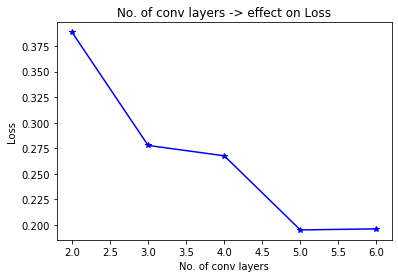

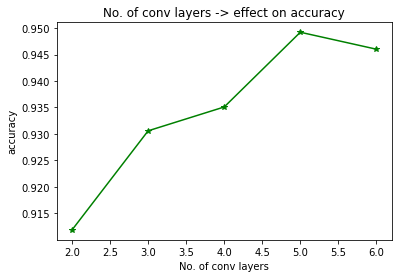

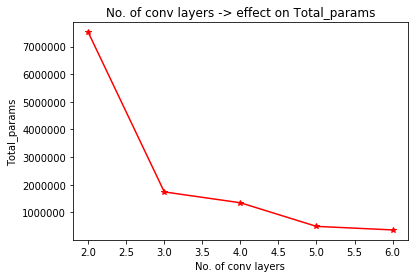

In [11]:
loss = [0]* 5;
Total_params = [0]*5;
accuracy = [0]*5;
conLayers = [2,3,4,5,6]

loss[0] = 0.3884
Total_params[0] = 7516234
accuracy[0] = 0.9119

loss[1] = 0.2778
Total_params[1] = 1741194
accuracy[1] = 0.9306

loss[2] = 0.2677
accuracy[2] = 0.9351
Total_params[2] = 1349066

loss[3] = 0.195272
accuracy[3] = 0.9492
Total_params[3] = 494602

loss[4] = 0.1963
accuracy[4] = 0.946
Total_params[4] = 366666


import matplotlib.pyplot as plt
plt.plot(conLayers,loss,'b-*')
plt.ylabel('Loss')
plt.xlabel('No. of conv layers')
plt.title('No. of conv layers -> effect on Loss')
plt.show()

import matplotlib.pyplot as plt
plt.plot(conLayers,accuracy,'g-*')
plt.ylabel('accuracy')
plt.xlabel('No. of conv layers')
plt.title('No. of conv layers -> effect on accuracy')
plt.show()

import matplotlib.pyplot as plt
plt.plot(conLayers,Total_params,'r-*')
plt.ylabel('Total_params')
plt.xlabel('No. of conv layers')
plt.title('No. of conv layers -> effect on Total_params')
plt.show()


### Saving all 5 models ...

In [13]:

model1.save('cnn_model.con2')
model2.save('cnn_model.con3')
model3.save('cnn_model.con4')
model4.save('cnn_model.con5')
model5.save('cnn_model.con6')


### Loading all 5 models ...

In [14]:
from keras.models import load_model

model1 = load_model('cnn_model.con2')
model2 = load_model('cnn_model.con3')
model3 = load_model('cnn_model.con4')
model4 = load_model('cnn_model.con5')
model5 = load_model('cnn_model.con6')


## part C

model 

2 fully Connected Layer. -> FCNs
Flattening -> Since it is a one dimensional Vector.
using DropOut inOrder to prevent Module from Overfitting ...


In [19]:
from __future__ import absolute_import
from __future__ import print_function
import os
import itertools
import numpy as np
import scipy.io
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense, Dropout, Activation, BatchNormalization,Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, Adadelta, Adagrad ,Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from keras.layers import Input

batch_size = 128
nb_classes = 10
nb_epoch = 20

model = Sequential()
# converting into one dimension Vector.
model.add(Flatten())

# fully Connected Layer 
model.add(Dense(4000))
model.add(Activation('relu'))
model.add(Dropout(0.25))

# fully Connected Layer
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=20, verbose=1, validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=0)
print('loss:', score[0])
print('accuracy:', score[1])

print(model.summary())
model1=model

C:\Users\AmirHossein\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:39: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 73257 samples, validate on 26032 samples
Epoch 1/20
73257/73257 [==============================] - 13s 178us/step - loss: 1.8176 - accuracy: 0.3922 - val_loss: 1.5088 - val_accuracy: 0.4960
Epoch 2/20
73257/73257 [==============================] - 13s 174us/step - loss: 1.2590 - accuracy: 0.6117 - val_loss: 1.3166 - val_accuracy: 0.6002
Epoch 3/20
73257/73257 [==============================] - 13s 173us/step - loss: 1.1268 - accuracy: 0.6523 - val_loss: 1.2224 - val_accuracy: 0.6031
Epoch 4/20
73257/73257 [==============================] - 13s 176us/step - loss: 1.0607 - accuracy: 0.6743 - val_loss: 1.1892 - val_accuracy: 0.6340
Epoch 5/20
73257/73257 [==============================] - 13s 176us/step - loss: 1.0109 - accuracy: 0.6891 - val_loss: 1.1979 - val_accuracy: 0.6270
Epoch 6/20
73257/73257 [==============================] - 13s 174us/step - loss: 0.9779 - accuracy: 0.6999 - val_loss: 1.0893 - val_accuracy: 0.6684
Epoch 7/20
73257/73257 [==============================] 

model 

3 fully Connected Layer. -> FCNs
Flattening -> Since it is a one dimensional Vector.
using DropOut inOrder to prevent Module from Overfitting ...


In [18]:
from __future__ import absolute_import
from __future__ import print_function
import os
import itertools
import numpy as np
import scipy.io
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense, Dropout, Activation, BatchNormalization,Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, Adadelta, Adagrad ,Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from keras.layers import Input

batch_size = 128
nb_classes = 10
nb_epoch = 20

model = Sequential()
# converting into one dimension Vector.
model.add(Flatten())

# fully Connected Layer 
model.add(Dense(4000))
model.add(Activation('relu'))
model.add(Dropout(0.25))

# fully Connected Layer
model.add(Dense(2000))
model.add(Activation('relu'))
model.add(Dropout(0.25))

# fully Connected Layer
model.add(Dense(nb_classes))
model.add(Activation('softmax'))


sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=20, verbose=1, validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=0)
print('loss:', score[0])
print('accuracy:', score[1])

print(model.summary())
model2=model

C:\Users\AmirHossein\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:45: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 73257 samples, validate on 26032 samples
Epoch 1/20
73257/73257 [==============================] - 19s 259us/step - loss: 1.9114 - accuracy: 0.3355 - val_loss: 1.6442 - val_accuracy: 0.4355
Epoch 2/20
73257/73257 [==============================] - 19s 254us/step - loss: 1.3016 - accuracy: 0.5823 - val_loss: 1.2468 - val_accuracy: 0.6263
Epoch 3/20
73257/73257 [==============================] - 19s 255us/step - loss: 1.1371 - accuracy: 0.6441 - val_loss: 1.2830 - val_accuracy: 0.6068
Epoch 4/20
73257/73257 [==============================] - 19s 257us/step - loss: 1.0564 - accuracy: 0.6717 - val_loss: 1.1182 - val_accuracy: 0.6600
Epoch 5/20
73257/73257 [==============================] - 19s 258us/step - loss: 1.0066 - accuracy: 0.6884 - val_loss: 1.0355 - val_accuracy: 0.6916
Epoch 6/20
73257/73257 [==============================] - 19s 258us/step - loss: 0.9638 - accuracy: 0.7004 - val_loss: 1.0474 - val_accuracy: 0.6842
Epoch 7/20
73257/73257 [==============================] 

model 

4 fully Connected Layer. -> FCNs
Flattening -> Since it is a one dimensional Vector.
using DropOut inOrder to prevent Module from Overfitting ...


In [17]:
from __future__ import absolute_import
from __future__ import print_function
import os
import itertools
import numpy as np
import scipy.io
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense, Dropout, Activation, BatchNormalization,Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, Adadelta, Adagrad ,Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from keras.layers import Input

batch_size = 128
nb_classes = 10
nb_epoch = 20

model = Sequential()
# converting into one dimension Vector.
model.add(Flatten())

# fully Connected Layer 
model.add(Dense(4000))
model.add(Activation('relu'))
model.add(Dropout(0.25))

# fully Connected Layer
model.add(Dense(2000))
model.add(Activation('relu'))
model.add(Dropout(0.25))

# fully Connected Layer
model.add(Dense(1000))
model.add(Activation('relu'))
model.add(Dropout(0.25))

# fully Connected Layer
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=20, verbose=1, validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=0)
print('loss:', score[0])
print('accuracy:', score[1])

print(model.summary())
model3=model

C:\Users\AmirHossein\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:49: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 73257 samples, validate on 26032 samples
Epoch 1/20
73257/73257 [==============================] - 20s 277us/step - loss: 2.1084 - accuracy: 0.2428 - val_loss: 1.6674 - val_accuracy: 0.4282
Epoch 2/20
73257/73257 [==============================] - 20s 276us/step - loss: 1.4622 - accuracy: 0.5132 - val_loss: 1.4111 - val_accuracy: 0.5443
Epoch 3/20
73257/73257 [==============================] - 21s 280us/step - loss: 1.2196 - accuracy: 0.6084 - val_loss: 1.3236 - val_accuracy: 0.5855
Epoch 4/20
73257/73257 [==============================] - 21s 283us/step - loss: 1.1272 - accuracy: 0.6404 - val_loss: 1.2107 - val_accuracy: 0.6283
Epoch 5/20
73257/73257 [==============================] - 20s 277us/step - loss: 1.0625 - accuracy: 0.6659 - val_loss: 1.1087 - val_accuracy: 0.6578
Epoch 6/20
73257/73257 [==============================] - 20s 278us/step - loss: 1.0187 - accuracy: 0.6792 - val_loss: 1.0020 - val_accuracy: 0.6976
Epoch 7/20
73257/73257 [==============================] 

model 

5 fully Connected Layer. -> FCNs
Flattening -> Since it is a one dimensional Vector.
using DropOut inOrder to prevent Module from Overfitting ...


In [16]:
from __future__ import absolute_import
from __future__ import print_function
import os
import itertools
import numpy as np
import scipy.io
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense, Dropout, Activation, BatchNormalization,Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, Adadelta, Adagrad ,Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from keras.layers import Input

batch_size = 128
nb_classes = 10
nb_epoch = 20

model = Sequential()
# converting into one dimension Vector.
model.add(Flatten())

# fully Connected Layer 
model.add(Dense(4000))
model.add(Activation('relu'))
model.add(Dropout(0.25))

# fully Connected Layer
model.add(Dense(2000))
model.add(Activation('relu'))
model.add(Dropout(0.25))

# fully Connected Layer
model.add(Dense(1000))
model.add(Activation('relu'))
model.add(Dropout(0.25))

# fully Connected Layer
model.add(Dense(500))
model.add(Activation('relu'))
model.add(Dropout(0.25))

# fully Connected Layer
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=20, verbose=1, validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=0)
print('loss:', score[0])
print('accuracy:', score[1])

print(model.summary())
model4=model

C:\Users\AmirHossein\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:54: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 73257 samples, validate on 26032 samples
Epoch 1/20
73257/73257 [==============================] - 21s 287us/step - loss: 2.2333 - accuracy: 0.1868 - val_loss: 2.1232 - val_accuracy: 0.2514
Epoch 2/20
73257/73257 [==============================] - 21s 284us/step - loss: 1.8224 - accuracy: 0.3545 - val_loss: 1.5984 - val_accuracy: 0.4652
Epoch 3/20
73257/73257 [==============================] - 21s 285us/step - loss: 1.4052 - accuracy: 0.5302 - val_loss: 1.3018 - val_accuracy: 0.5819
Epoch 4/20
73257/73257 [==============================] - 21s 288us/step - loss: 1.2450 - accuracy: 0.5932 - val_loss: 1.3475 - val_accuracy: 0.5778
Epoch 5/20
73257/73257 [==============================] - 21s 288us/step - loss: 1.1650 - accuracy: 0.6237 - val_loss: 1.2644 - val_accuracy: 0.6011
Epoch 6/20
73257/73257 [==============================] - 21s 288us/step - loss: 1.1020 - accuracy: 0.6463 - val_loss: 1.1385 - val_accuracy: 0.6386
Epoch 7/20
73257/73257 [==============================] 

In [ ]:
model 

6 fully Connected Layer. -> FCNs
Flattening -> Since it is a one dimensional Vector.
using DropOut inOrder to prevent Module from Overfitting ...


In [15]:
from __future__ import absolute_import
from __future__ import print_function
import os
import itertools
import numpy as np
import scipy.io
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense, Dropout, Activation, BatchNormalization,Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, Adadelta, Adagrad ,Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from keras.layers import Input

batch_size = 128
nb_classes = 10
nb_epoch = 20

model = Sequential()
# converting into one dimension Vector.
model.add(Flatten())

# fully Connected Layer 
model.add(Dense(4000))
model.add(Activation('relu'))
model.add(Dropout(0.25))

# fully Connected Layer
model.add(Dense(2000))
model.add(Activation('relu'))
model.add(Dropout(0.25))

# fully Connected Layer
model.add(Dense(1000))
model.add(Activation('relu'))
model.add(Dropout(0.25))

# fully Connected Layer
model.add(Dense(500))
model.add(Activation('relu'))
model.add(Dropout(0.25))

# fully Connected Layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.25))

# fully Connected Layer
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=20, verbose=1, validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=0)
print('loss:', score[0])
print('accuracy:', score[1])

print(model.summary())
model5=model

C:\Users\AmirHossein\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:59: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 73257 samples, validate on 26032 samples
Epoch 1/20
73257/73257 [==============================] - 34s 464us/step - loss: 2.2476 - accuracy: 0.1858 - val_loss: 2.2237 - val_accuracy: 0.1959
Epoch 2/20
73257/73257 [==============================] - 21s 290us/step - loss: 2.1853 - accuracy: 0.2010 - val_loss: 2.0281 - val_accuracy: 0.2577
Epoch 3/20
73257/73257 [==============================] - 21s 284us/step - loss: 1.8301 - accuracy: 0.3424 - val_loss: 1.7025 - val_accuracy: 0.4003
Epoch 4/20
73257/73257 [==============================] - 21s 287us/step - loss: 1.5725 - accuracy: 0.4511 - val_loss: 1.4601 - val_accuracy: 0.5196
Epoch 5/20
73257/73257 [==============================] - 21s 290us/step - loss: 1.4096 - accuracy: 0.5221 - val_loss: 1.6991 - val_accuracy: 0.4511
Epoch 6/20
73257/73257 [==============================] - 21s 290us/step - loss: 1.3184 - accuracy: 0.5593 - val_loss: 1.2216 - val_accuracy: 0.6077
Epoch 7/20
73257/73257 [==============================] 

### comparison

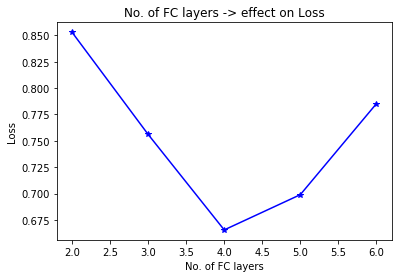

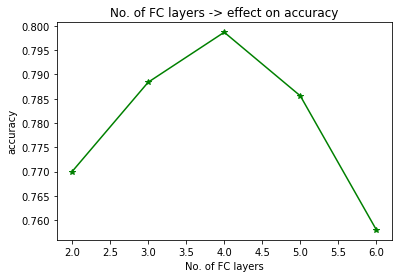

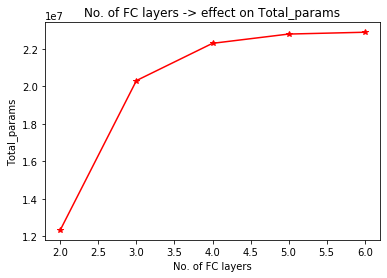

In [12]:
loss = [0]* 5;
Total_params = [0]*5;
accuracy = [0]*5;
conLayers = [2,3,4,5,6]

loss[0] = 0.8529
Total_params[0] = 12332010
accuracy[0] = 0.77

loss[1] = 0.7561
Total_params[1] = 20314010
accuracy[1] = 0.7884

loss[2] = 0.6656
accuracy[2] = 0.7987
Total_params[2] = 22305010

loss[3] = 0.6990
accuracy[3] = 0.7856
Total_params[3] = 22800510

loss[4] = 0.7852
accuracy[4] = 0.7580
Total_params[4] = 22897710


import matplotlib.pyplot as plt
plt.plot(conLayers,loss,'b-*')
plt.ylabel('Loss')
plt.xlabel('No. of FC layers')
plt.title('No. of FC layers -> effect on Loss')
plt.show()

import matplotlib.pyplot as plt
plt.plot(conLayers,accuracy,'g-*')
plt.ylabel('accuracy')
plt.xlabel('No. of FC layers')
plt.title('No. of FC layers -> effect on accuracy')
plt.show()

import matplotlib.pyplot as plt
plt.plot(conLayers,Total_params,'r-*')
plt.ylabel('Total_params')
plt.xlabel('No. of FC layers')
plt.title('No. of FC layers -> effect on Total_params')
plt.show()


### Saving and Loading all 5 models ...

In [20]:
from keras.models import load_model

model1.save('fcn_model.layerNum2')
model2.save('fcn_model.layerNum3')
model3.save('fcn_model.layerNum4')
model4.save('fcn_model.layerNum5')
model5.save('fcn_model.layerNum6')

model1 = load_model('fcn_model.layerNum2')
model2 = load_model('fcn_model.layerNum3')
model3 = load_model('fcn_model.layerNum4')
model4 = load_model('fcn_model.layerNum5')
model5 = load_model('fcn_model.layerNum6')


## part d

### visualiztion: 1- CNN with 2 conv Layers

(3, 3, 3, 128)


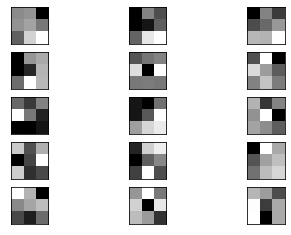

In [52]:

from matplotlib import pyplot
# load the model

model1 = load_model('cnn_model.con2')
# model2 = load_model('cnn_model.con3')
# model3 = load_model('cnn_model.con4')
# model4 = load_model('cnn_model.con5')
# model5 = load_model('cnn_model.con6')
model = model1

# retrieve weights from the second hidden layer
filters, biases = model.layers[0].get_weights()

# get min and max filters ...
# normalize filter values to 0-1 by 
# division by (f_max - f_min) 
# so we can visualize them
f_min, f_max = filters.min(), filters.max()
# normalizing...
filters = (filters - f_min) / (f_max - f_min)
# plot first some filters

print(filters.shape)

# let's draw some of them.
noOfFilters, ix = 5, 1
for i in range(noOfFilters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(3):
        # specify subplot and turn of axis
        ax = pyplot.subplot(noOfFilters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(f[:, :, j], cmap='gray')
        ix += 1
# show the figure
pyplot.show()



### CNN with 3 conv Layers

(3, 3, 128, 64)


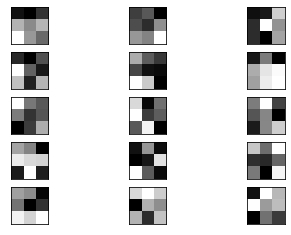

In [51]:

from matplotlib import pyplot
# load the model

# model1 = load_model('cnn_model.con2')
model2 = load_model('cnn_model.con3')
# model3 = load_model('cnn_model.con4')
# model4 = load_model('cnn_model.con5')
# model5 = load_model('cnn_model.con6')
model = model2

# retrieve weights from the second hidden layer
filters, biases = model.layers[3].get_weights()

# get min and max filters ...
# normalize filter values to 0-1 by 
# division by (f_max - f_min) 
# so we can visualize them
f_min, f_max = filters.min(), filters.max()
# normalizing...
filters = (filters - f_min) / (f_max - f_min)
# plot first some filters

print(filters.shape)

# let's draw some of them.
noOfFilters, ix = 5, 1
for i in range(noOfFilters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(3):
        # specify subplot and turn of axis
        ax = pyplot.subplot(noOfFilters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(f[:, :, j], cmap='gray')
        ix += 1
# show the figure
pyplot.show()


### CNN with 4 conv Layers

(3, 3, 64, 64)


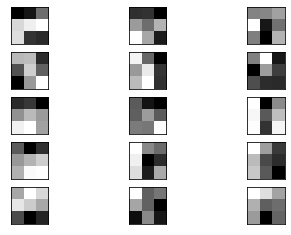

In [50]:

from matplotlib import pyplot
# load the model

# model1 = load_model('cnn_model.con2')
# model2 = load_model('cnn_model.con3')
model3 = load_model('cnn_model.con4')
# model4 = load_model('cnn_model.con5')
# model5 = load_model('cnn_model.con6')
model = model3

# retrieve weights from the second hidden layer
filters, biases = model.layers[8].get_weights()

# get min and max filters ...
# normalize filter values to 0-1 by 
# division by (f_max - f_min) 
# so we can visualize them
f_min, f_max = filters.min(), filters.max()
# normalizing...
filters = (filters - f_min) / (f_max - f_min)
# plot first some filters

print(filters.shape)

# let's draw some of them.
noOfFilters, ix = 5, 1
for i in range(noOfFilters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(3):
        # specify subplot and turn of axis
        ax = pyplot.subplot(noOfFilters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(f[:, :, j], cmap='gray')
        ix += 1
# show the figure
pyplot.show()


### CNN with 5 conv Layers

(3, 3, 64, 64)


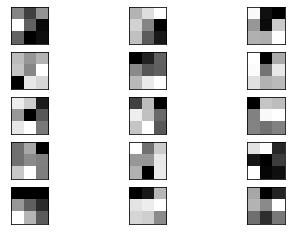

In [49]:

from matplotlib import pyplot
# load the model

# model1 = load_model('cnn_model.con2')
# model2 = load_model('cnn_model.con3')
# model3 = load_model('cnn_model.con4')
model4 = load_model('cnn_model.con5')
# model5 = load_model('cnn_model.con6')
model = model4

# retrieve weights from the second hidden layer
filters, biases = model.layers[11].get_weights()

# get min and max filters ...
# normalize filter values to 0-1 by 
# division by (f_max - f_min) 
# so we can visualize them
f_min, f_max = filters.min(), filters.max()
# normalizing...
filters = (filters - f_min) / (f_max - f_min)
# plot first some filters

print(filters.shape)

# let's draw some of them.
noOfFilters, ix = 5, 1
for i in range(noOfFilters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(3):
        # specify subplot and turn of axis
        ax = pyplot.subplot(noOfFilters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(f[:, :, j], cmap='gray')
        ix += 1
# show the figure
pyplot.show()


### CNN with 6 conv Layers

(3, 3, 64, 64)


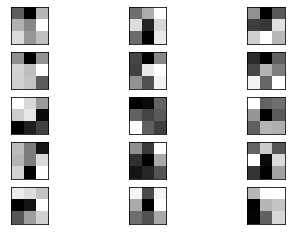

In [48]:

from matplotlib import pyplot

# load the model
# model1 = load_model('cnn_model.con2')
# model2 = load_model('cnn_model.con3')
# model3 = load_model('cnn_model.con4')
# model4 = load_model('cnn_model.con5')
model5 = load_model('cnn_model.con6')
model = model5

# retrieve weights from the second hidden layer
filters, biases = model.layers[16].get_weights()

# get min and max filters ...
# normalize filter values to 0-1 by 
# division by (f_max - f_min) 
# so we can visualize them
f_min, f_max = filters.min(), filters.max()
# normalizing...
filters = (filters - f_min) / (f_max - f_min)
# plot first some filters

print(filters.shape)

# let's draw some of them.
noOfFilters, ix = 5, 1
for i in range(noOfFilters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(3):
        # specify subplot and turn of axis
        ax = pyplot.subplot(noOfFilters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(f[:, :, j], cmap='gray')
        ix += 1
# show the figure
pyplot.show()


### feature map


Testing feature map with 
the first Layer of Convoloution Layers
with some pictures.


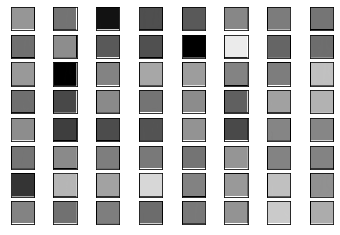

In [66]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.resnet50 import preprocess_input
from keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims

# load the model
# model1 = load_model('cnn_model.con2')
# model2 = load_model('cnn_model.con3')
# model3 = load_model('cnn_model.con4')
# model4 = load_model('cnn_model.con5')
model5 = load_model('cnn_model.con6')

# uncomment one of them
# let's do this.
model = model5

# extracting first Convoloutional layer.
model = Model(inputs=model.inputs, outputs=model.layers[0].output)

# test with the first Image :)
img =X_train[0]

#
# test with any image you want
# simply change index from 0 to any
# other image you want.
#

# preprocess the image
img = img_to_array(img)
img = expand_dims(img, axis=0)
img = preprocess_input(img)

# let's predict the image.
feature_maps = model.predict(img)

square = 8
ix = 1
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = pyplot.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale Mode.
        pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1
# show the figure
pyplot.show()


## part e : 1 - CNN

### usefulFunctions

In [1]:
# useful functions ...

def extractChannelsAndNormalize(img):
    firstChannel = img[i:i + 32,j:j + 32,0]
    firstChannelReshaped = np.reshape(firstChannel, (1, 32*32))
        
    SecondChannel = img[i:i + 32,j:j + 32,1]
    secondChannelReshaped = np.reshape(SecondChannel, (1, 32*32))
        
    ThirdChannel = img[i:i + 32,j:j + 32,2]
    thirdChannelReshaped = np.reshape(ThirdChannel, (1, 32*32))
        
    finalMergedChannels = np.concatenate((firstChannelReshaped, secondChannelReshaped), axis=1)
    finalMergedChannels = np.concatenate((finalMergedChannels, thirdChannelReshaped), axis=1)
    finalMergedChannels = finalMergedChannels.reshape(1,  32, 32,3)
    finalMergedChannels = finalMergedChannels.astype('float32')
    finalMergedChannels /= 255
    
    return finalMergedChannels
    

### ّFirstImage

DetectedClassTpossibilitype
1
DetectedProbabilitpossibility
0.9996284


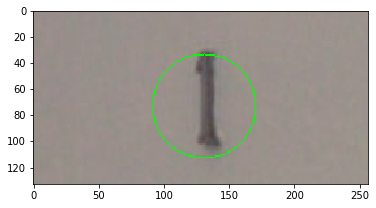

In [10]:
from __future__ import absolute_import
from __future__ import print_function
import os
import cv2
import itertools
import numpy as np
import scipy.io
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense, Dropout, Activation, BatchNormalization,Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, Adadelta, Adagrad ,Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from keras.layers import Input
from keras.models import load_model

# simply choose one of them
# I chosed model with 6 con layers
# load the model
# model1 = load_model('cnn_model.con2')
# model2 = load_model('cnn_model.con3')
# model3 = load_model('cnn_model.con4')
# model4 = load_model('cnn_model.con5')
model = load_model('cnn_model.con6')

## todo change
img = cv2.imread('Numbers/1.png') 

height, width, channels = img.shape 
classTpossibilitype,TruthProbThreshold,topLeftWindowIndex_i,topLeftWindowIndex_j= 0,0,0,0

for i in range(1, height - 32, 2):
    for j in range(1, width - 32, 2):
        
        extracted = extractChannelsAndNormalize(img)
        predictedClass = model.predict_classes(extracted)
        possibility = model.predict(extracted)
  
        # finding maximum possibility during 
        # all fors tricky :))
        
        if(TruthProbThreshold<possibility[0][predictedClass[0]]):
            topLeftWindowIndex_i = i
            topLeftWindowIndex_j = j
            classTpossibilitype=predictedClass[0]
            TruthProbThreshold=possibility[0][predictedClass[0]]

print('DetectedClassTpossibilitype')
print(classTpossibilitype)
print('DetectedProbabilitpossibility')
print(TruthProbThreshold)

cv2.circle(img,(topLeftWindowIndex_j+16,topLeftWindowIndex_i+16), 40, (0,255,0), 1)
cv2.imshow("Bordering Founded Number",img)
cv2.waitKey()
cv2.destroyAllWindows()

from matplotlib import pyplot
pyplot.imshow(img)
pyplot.show()

### SecondImage

DetectedClassTpossibilitype
1
DetectedProbabilitpossibility
0.9973266


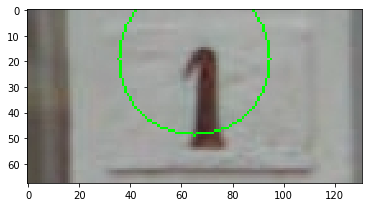

In [6]:
from __future__ import absolute_import
from __future__ import print_function
from keras.models import load_model
import os
import cv2
import itertools
import numpy as np
import scipy.io
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense, Dropout, Activation, BatchNormalization,Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, Adadelta, Adagrad ,Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from keras.layers import Input

# simply choose one of them
# I chosed model with 6 con layers
# load the model
# model1 = load_model('cnn_model.con2')
# model2 = load_model('cnn_model.con3')
# model3 = load_model('cnn_model.con4')
# model4 = load_model('cnn_model.con5')
model = load_model('cnn_model.con6')

## todo change
img = cv2.imread('Numbers/1_1.png') 

height, width, channels = img.shape 
classTpossibilitype,TruthProbThreshold,topLeftWindowIndex_i,topLeftWindowIndex_j= 0,0,0,0

for i in range(1, height - 32, 2):
    for j in range(1, width - 32, 2):
        
        extracted = extractChannelsAndNormalize(img)
        predictedClass = model.predict_classes(extracted)
        possibility = model.predict(extracted)
  
        # finding maximum possibility during 
        # all fors tricky!!!
        
        if(TruthProbThreshold<possibility[0][predictedClass[0]]):
            topLeftWindowIndex_i = i
            topLeftWindowIndex_j = j
            classTpossibilitype=predictedClass[0]
            TruthProbThreshold=possibility[0][predictedClass[0]]

print('DetectedClassTpossibilitype')
print(classTpossibilitype)
print('DetectedProbabilitpossibility')
print(TruthProbThreshold)

cv2.circle(img,(topLeftWindowIndex_j,topLeftWindowIndex_i), 30, (0,255,0), 1)
cv2.imshow("Bordering Founded Number",img)
cv2.waitKey()
cv2.destroyAllWindows()

from matplotlib import pyplot
pyplot.imshow(img)
pyplot.show()

### ThirdImage

DetectedClassTpossibilitype
1
DetectedProbabilitpossibility
0.9989341


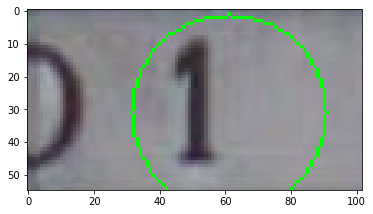

In [4]:
from __future__ import absolute_import
from __future__ import print_function
from keras.models import load_model
import os
import cv2
import itertools
import numpy as np
import scipy.io
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense, Dropout, Activation, BatchNormalization,Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, Adadelta, Adagrad ,Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from keras.layers import Input


# simply choose one of them
# I chosed model with 6 con layers
# load the model
# model1 = load_model('cnn_model.con2')
# model2 = load_model('cnn_model.con3')
# model3 = load_model('cnn_model.con4')
# model4 = load_model('cnn_model.con5')
model = load_model('cnn_model.con6')


## todo change
img = cv2.imread('Numbers/1_2.png') 

height, width, channels = img.shape 
classTpossibilitype,TruthProbThreshold,topLeftWindowIndex_i,topLeftWindowIndex_j= 0,0,0,0

for i in range(1, height - 32, 2):
    for j in range(1, width - 32, 2):
        
        extracted = extractChannelsAndNormalize(img)
        predictedClass = model.predict_classes(extracted)
        possibility = model.predict(extracted)
  
        # finding maximum possibility during 
        # all fors tricky!!!
        
        if(TruthProbThreshold<possibility[0][predictedClass[0]]):
            topLeftWindowIndex_i = i
            topLeftWindowIndex_j = j
            classTpossibilitype=predictedClass[0]
            TruthProbThreshold=possibility[0][predictedClass[0]]

print('DetectedClassTpossibilitype')
print(classTpossibilitype)
print('DetectedProbabilitpossibility')
print(TruthProbThreshold)

cv2.circle(img,(topLeftWindowIndex_j+16,topLeftWindowIndex_i+16), 30, (0,255,0), 1)
cv2.imshow("Bordering Founded Number",img)
cv2.waitKey()
cv2.destroyAllWindows()

from matplotlib import pyplot
pyplot.imshow(img)
pyplot.show()

### ForthImage

DetectedClassTpossibilitype
1
DetectedProbabilitpossibility
0.9988501


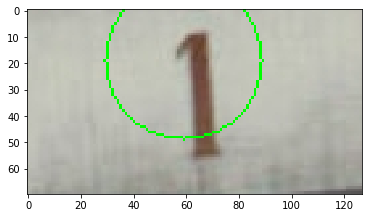

In [5]:
from __future__ import absolute_import
from __future__ import print_function
from keras.models import load_model
import os
import cv2
import itertools
import numpy as np
import scipy.io
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense, Dropout, Activation, BatchNormalization,Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, Adadelta, Adagrad ,Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from keras.layers import Input

# simply choose one of them
# I chosed model with 6 con layers
# load the model
# model1 = load_model('cnn_model.con2')
# model2 = load_model('cnn_model.con3')
# model3 = load_model('cnn_model.con4')
# model4 = load_model('cnn_model.con5')
model = load_model('cnn_model.con6')

## todo change
img = cv2.imread('Numbers/1_3.png') 

height, width, channels = img.shape 
classTpossibilitype,TruthProbThreshold,topLeftWindowIndex_i,topLeftWindowIndex_j= 0,0,0,0

for i in range(1, height - 32, 2):
    for j in range(1, width - 32, 2):
        
        extracted = extractChannelsAndNormalize(img)
        predictedClass = model.predict_classes(extracted)
        possibility = model.predict(extracted)
  
        # finding maximum possibility during 
        # all fors tricky!!!
        
        if(TruthProbThreshold<possibility[0][predictedClass[0]]):
            topLeftWindowIndex_i = i
            topLeftWindowIndex_j = j
            classTpossibilitype=predictedClass[0]
            TruthProbThreshold=possibility[0][predictedClass[0]]

print('DetectedClassTpossibilitype')
print(classTpossibilitype)
print('DetectedProbabilitpossibility')
print(TruthProbThreshold)

cv2.circle(img,(topLeftWindowIndex_j,topLeftWindowIndex_i), 30, (0,255,0), 1)
cv2.imshow("Bordering Founded Number",img)
cv2.waitKey()
cv2.destroyAllWindows()

from matplotlib import pyplot
pyplot.imshow(img)
pyplot.show()

### FifthImage

DetectedClassTpossibilitype
1
DetectedProbabilitpossibility
0.9969716


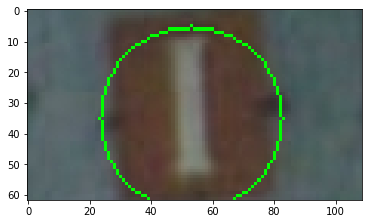

In [6]:
from __future__ import absolute_import
from __future__ import print_function
from keras.models import load_model
import os
import cv2
import itertools
import numpy as np
import scipy.io
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense, Dropout, Activation, BatchNormalization,Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, Adadelta, Adagrad ,Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from keras.layers import Input

# simply choose one of them
# I chosed model with 6 con layers
# load the model
# model1 = load_model('cnn_model.con2')
# model2 = load_model('cnn_model.con3')
# model3 = load_model('cnn_model.con4')
# model4 = load_model('cnn_model.con5')
model = load_model('cnn_model.con6')


## todo change
img = cv2.imread('Numbers/1_4.png') 

height, width, channels = img.shape 
classTpossibilitype,TruthProbThreshold,topLeftWindowIndex_i,topLeftWindowIndex_j= 0,0,0,0

for i in range(1, height - 32, 2):
    for j in range(1, width - 32, 2):
        
        extracted = extractChannelsAndNormalize(img)
        predictedClass = model.predict_classes(extracted)
        possibility = model.predict(extracted)
  
        # finding maximum possibility during 
        # all fors in a tricky method!!!
        
        if(TruthProbThreshold<possibility[0][predictedClass[0]]):
            topLeftWindowIndex_i = i
            topLeftWindowIndex_j = j
            classTpossibilitype=predictedClass[0]
            TruthProbThreshold=possibility[0][predictedClass[0]]

print('DetectedClassTpossibilitype')
print(classTpossibilitype)
print('DetectedProbabilitpossibility')
print(TruthProbThreshold)

cv2.circle(img,(topLeftWindowIndex_j+16,topLeftWindowIndex_i+16), 30, (0,255,0), 1)
cv2.imshow("Bordering Founded Number",img)
cv2.waitKey()
cv2.destroyAllWindows()

from matplotlib import pyplot
pyplot.imshow(img)
pyplot.show()

## part e : 2 - Fully Connected

### FirstImage

Using TensorFlow backend.


DetectedClassTpossibilitype
4
DetectedProbabilitpossibility
0.74285775


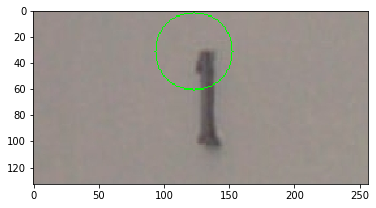

In [2]:
from __future__ import absolute_import
from __future__ import print_function
from keras.models import load_model
import os
import cv2
import itertools
import numpy as np
import scipy.io
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense, Dropout, Activation, BatchNormalization,Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, Adadelta, Adagrad ,Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from keras.layers import Input

# simply choose one of them
# I chosed model with 6 fully connected layers
# load the model
# model1 = load_model('fcn_model.layerNum2')
# model2 = load_model('fcn_model.layerNum3')
# model3 = load_model('fcn_model.layerNum4')
# model4 = load_model('fcn_model.layerNum5')
model = load_model('fcn_model.layerNum6')


## todo change
img = cv2.imread('Numbers/1.png') 

height, width, channels = img.shape 
classTpossibilitype,TruthProbThreshold,topLeftWindowIndex_i,topLeftWindowIndex_j= 0,0,0,0

for i in range(1+10, height - 32, 2):
    for j in range(65, width - 32, 2):
        
        extracted = extractChannelsAndNormalize(img)
        predictedClass = model.predict_classes(extracted)
        possibility = model.predict(extracted)
  
        # finding maximum possibility during 
        # all fors in a tricky method!!!
        
        if(TruthProbThreshold<possibility[0][predictedClass[0]]):
            if(predictedClass[0]!=1):
                topLeftWindowIndex_i = i
                topLeftWindowIndex_j = j
                classTpossibilitype=predictedClass[0]
                TruthProbThreshold=possibility[0][predictedClass[0]]

print('DetectedClassTpossibilitype')
print(classTpossibilitype)
print('DetectedProbabilitpossibility')
print(TruthProbThreshold)

cv2.circle(img,(topLeftWindowIndex_j+16,topLeftWindowIndex_i+16), 30, (0,255,0), 1)
cv2.imshow("Bordering Founded Number",img)
cv2.waitKey()
cv2.destroyAllWindows()

from matplotlib import pyplot
pyplot.imshow(img)
pyplot.show()

### SecondImage

DetectedClassTpossibilitype
9
DetectedProbabilitpossibility
0.3721647


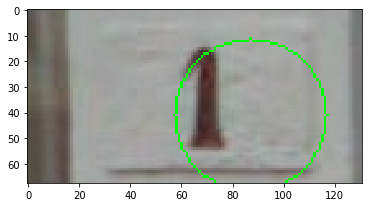

In [3]:
from __future__ import absolute_import
from __future__ import print_function
from keras.models import load_model
import os
import cv2
import itertools
import numpy as np
import scipy.io
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense, Dropout, Activation, BatchNormalization,Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, Adadelta, Adagrad ,Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from keras.layers import Input

# simply choose one of them
# I chosed model with 6 fully connected layers
# load the model
# model1 = load_model('fcn_model.layerNum2')
# model2 = load_model('fcn_model.layerNum3')
# model3 = load_model('fcn_model.layerNum4')
# model4 = load_model('fcn_model.layerNum5')
model = load_model('fcn_model.layerNum6')


## todo change
img = cv2.imread('Numbers/1_1.png') 

height, width, channels = img.shape 
classTpossibilitype,TruthProbThreshold,topLeftWindowIndex_i,topLeftWindowIndex_j= 0,0,0,0

for i in range(1+10, height - 32, 2):
    for j in range(65, width - 32, 2):
        
        extracted = extractChannelsAndNormalize(img)
        predictedClass = model.predict_classes(extracted)
        possibility = model.predict(extracted)
  
        # finding maximum possibility during 
        # all fors in a tricky method!!!
        
        if(TruthProbThreshold<possibility[0][predictedClass[0]]):
            if(predictedClass[0]!=1):
                topLeftWindowIndex_i = i
                topLeftWindowIndex_j = j
                classTpossibilitype=predictedClass[0]
                TruthProbThreshold=possibility[0][predictedClass[0]]

print('DetectedClassTpossibilitype')
print(classTpossibilitype)
print('DetectedProbabilitpossibility')
print(TruthProbThreshold)

cv2.circle(img,(topLeftWindowIndex_j+16,topLeftWindowIndex_i+16), 30, (0,255,0), 1)
cv2.imshow("Bordering Founded Number",img)
cv2.waitKey()
cv2.destroyAllWindows()

from matplotlib import pyplot
pyplot.imshow(img)
pyplot.show()

### ThirdImage

DetectedClassTpossibilitype
0
DetectedProbabilitpossibility
0.18160039


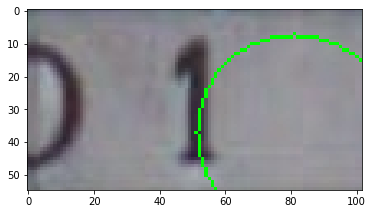

In [7]:
from __future__ import absolute_import
from __future__ import print_function
from keras.models import load_model
import os
import cv2
import itertools
import numpy as np
import scipy.io
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense, Dropout, Activation, BatchNormalization,Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, Adadelta, Adagrad ,Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from keras.layers import Input

# simply choose one of them
# I chosed model with 6 fully connected layers
# load the model
# model1 = load_model('fcn_model.layerNum2')
# model2 = load_model('fcn_model.layerNum3')
# model3 = load_model('fcn_model.layerNum4')
# model4 = load_model('fcn_model.layerNum5')
model = load_model('fcn_model.layerNum6')


## todo change
img = cv2.imread('Numbers/1_2.png') 

height, width, channels = img.shape 
classTpossibilitype,TruthProbThreshold,topLeftWindowIndex_i,topLeftWindowIndex_j= 0,0,0,0

for i in range(1+10, height - 32, 2):
    for j in range(65, width - 32, 2):
        
        extracted = extractChannelsAndNormalize(img)
        predictedClass = model.predict_classes(extracted)
        possibility = model.predict(extracted)
  
        # finding maximum possibility during 
        # all fors in a tricky method!!!
        
        if(TruthProbThreshold<possibility[0][predictedClass[0]]):
            if(predictedClass[0]!=1):
                topLeftWindowIndex_i = i
                topLeftWindowIndex_j = j
                classTpossibilitype=predictedClass[0]
                TruthProbThreshold=possibility[0][predictedClass[0]]

print('DetectedClassTpossibilitype')
print(classTpossibilitype)
print('DetectedProbabilitpossibility')
print(TruthProbThreshold)

cv2.circle(img,(topLeftWindowIndex_j+16,topLeftWindowIndex_i+16), 30, (0,255,0), 1)
cv2.imshow("Bordering Founded Number",img)
cv2.waitKey()
cv2.destroyAllWindows()

from matplotlib import pyplot
pyplot.imshow(img)
pyplot.show()

### ForthImage

DetectedClassTpossibilitype
9
DetectedProbabilitpossibility
0.43721744


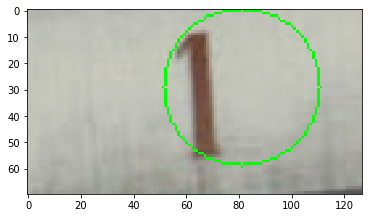

In [8]:
from __future__ import absolute_import
from __future__ import print_function
from keras.models import load_model
import os
import cv2
import itertools
import numpy as np
import scipy.io
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense, Dropout, Activation, BatchNormalization,Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, Adadelta, Adagrad ,Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from keras.layers import Input

# simply choose one of them
# I chosed model with 6 fully connected layers
# load the model
# model1 = load_model('fcn_model.layerNum2')
# model2 = load_model('fcn_model.layerNum3')
# model3 = load_model('fcn_model.layerNum4')
# model4 = load_model('fcn_model.layerNum5')
model = load_model('fcn_model.layerNum6')


## todo change
img = cv2.imread('Numbers/1_3.png') 

height, width, channels = img.shape 
classTpossibilitype,TruthProbThreshold,topLeftWindowIndex_i,topLeftWindowIndex_j= 0,0,0,0

for i in range(1+10, height - 32, 2):
    for j in range(65, width - 32, 2):
        
        extracted = extractChannelsAndNormalize(img)
        predictedClass = model.predict_classes(extracted)
        possibility = model.predict(extracted)
  
        # finding maximum possibility during 
        # all fors in a tricky method!!!
        
        if(TruthProbThreshold<possibility[0][predictedClass[0]]):
            if(predictedClass[0]!=1):
                topLeftWindowIndex_i = i
                topLeftWindowIndex_j = j
                classTpossibilitype=predictedClass[0]
                TruthProbThreshold=possibility[0][predictedClass[0]]

print('DetectedClassTpossibilitype')
print(classTpossibilitype)
print('DetectedProbabilitpossibility')
print(TruthProbThreshold)

cv2.circle(img,(topLeftWindowIndex_j+16,topLeftWindowIndex_i+16), 30, (0,255,0), 1)
cv2.imshow("Bordering Founded Number",img)
cv2.waitKey()
cv2.destroyAllWindows()

from matplotlib import pyplot
pyplot.imshow(img)
pyplot.show()

### FifthImage

DetectedClassTpossibilitype
7
DetectedProbabilitpossibility
0.25970483


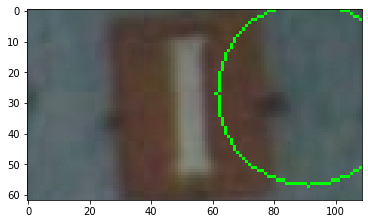

In [9]:
from __future__ import absolute_import
from __future__ import print_function
from keras.models import load_model
import os
import cv2
import itertools
import numpy as np
import scipy.io
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense, Dropout, Activation, BatchNormalization,Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, Adadelta, Adagrad ,Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from keras.layers import Input

# simply choose one of them
# I chosed model with 6 fully connected layers
# load the model
# model1 = load_model('fcn_model.layerNum2')
# model2 = load_model('fcn_model.layerNum3')
# model3 = load_model('fcn_model.layerNum4')
# model4 = load_model('fcn_model.layerNum5')
model = load_model('fcn_model.layerNum6')


## todo change
img = cv2.imread('Numbers/1_4.png') 

height, width, channels = img.shape 
classTpossibilitype,TruthProbThreshold,topLeftWindowIndex_i,topLeftWindowIndex_j= 0,0,0,0

for i in range(1+10, height - 32, 2):
    for j in range(65, width - 32, 2):
        
        extracted = extractChannelsAndNormalize(img)
        predictedClass = model.predict_classes(extracted)
        possibility = model.predict(extracted)
  
        # finding maximum possibility during 
        # all fors in a tricky method!!!
        
        if(TruthProbThreshold<possibility[0][predictedClass[0]]):
            if(predictedClass[0]!=1):
                topLeftWindowIndex_i = i
                topLeftWindowIndex_j = j
                classTpossibilitype=predictedClass[0]
                TruthProbThreshold=possibility[0][predictedClass[0]]

print('DetectedClassTpossibilitype')
print(classTpossibilitype)
print('DetectedProbabilitpossibility')
print(TruthProbThreshold)

cv2.circle(img,(topLeftWindowIndex_j+16,topLeftWindowIndex_i+16), 30, (0,255,0), 1)
cv2.imshow("Bordering Founded Number",img)
cv2.waitKey()
cv2.destroyAllWindows()

from matplotlib import pyplot
pyplot.imshow(img)
pyplot.show()